<a href="https://www.kaggle.com/code/angelchaudhary/customer-segmentation-for-e-commerce?scriptVersionId=293118508" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Customer Segmentation & Personalization Using Behavioral Clustering"

# Introduction
Most e-commerce platforms treat all customers the same, the same discounts, the same emails, the same product recommendations.  
This leads to wasted marketing spend, lower conversions, and poor customer experience.

The real question is:
**Can we group customers based on how they actually behave and personalize strategies for each group?**

Customer segmentation is one of the most valuable data science applications in business. Companies like Amazon, Flipkart, and Meesho rely on behavioral segmentation to:

- Target the right users with the right offers  
- Increase repeat purchases  
- Reduce churn  
- Improve lifetime value  

## Approach

In this project, we will:

1. Analyze customer behavior such as purchases, frequency, and spending  
2. Reduce dimensionality using **PCA** to understand structure in the data  
3. Segment customers using **KMeans and DBSCAN clustering**  
4. Profile each cluster to understand:
   - Who they are  
   - How they shop  
   - How valuable they are  
5. Recommend **marketing and personalization strategies** for each segment  

# LET'S DO IT!!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3dWJrN3RrbzBhZzRhb3ZqemZvOGFiOWxhOGZtNDRicmx5eXliZ3hmaSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/320DfGXqFd5stx7yWS/giphy.gif)

## Dataset Overview

This project uses the **Online Retail Dataset**, which contains real transaction data from a UK-based online retail store. Each row represents a product purchased by a customer in a single order. The dataset includes information such as invoice number, product details, quantity, price, purchase date, customer ID, and country. This data allows us to analyze **how often customers buy, how much they spend, and how recently they purchased**, which are the core signals needed for customer segmentation and personalization.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ulrikthygepedersen/online-retail-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/online-retail-dataset


In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/online-retail-dataset/online_retail.csv")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Remove rows without CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove cancelled orders (InvoiceNo starts with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Remove negative or zero quantity and price
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create total amount spent per transaction
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.shape

(397884, 9)

## RFM Feature Engineering 
- Recency → Days since last purchase
- Frequency → Number of orders
- Monetary → Total spend

In [7]:
# Reference date (last date in dataset)
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
# Create RFM table
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,   # Recency
    "InvoiceNo": "nunique",                                     # Frequency
    "TotalPrice": "sum"                                         # Monetary
})
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


#### RFM Feature Engineering

We transformed transaction-level data into **customer-level behavior** using three key metrics:

- **Recency**: How many days since the customer’s last purchase  
- **Frequency**: How many orders the customer has placed  
- **Monetary**: How much total money the customer has spent  

Each row in this table now represents **one customer** allowing us to compare and cluster customers based on how they shop rather than what they buy.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled[:5]

array([[ 2.33457414, -0.4250965 ,  8.35866818],
       [-0.90534032,  0.3544168 ,  0.25096626],
       [-0.17535959, -0.03533985, -0.02859601],
       [-0.73534481, -0.4250965 , -0.0330118 ],
       [ 2.17457836, -0.4250965 , -0.19134727]])

## PCA (Customer Structure)

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

pca.explained_variance_ratio_

array([0.55502102, 0.30249315])

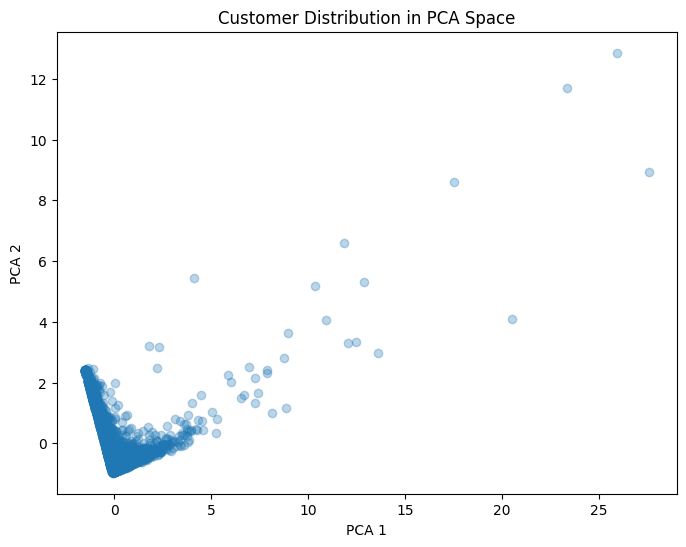

In [10]:
# Plot customers in PCA space
plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], alpha=0.3)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Distribution in PCA Space")
plt.show()

#### PCA Observation

The PCA scatter plot shows that most customers are concentrated in a dense region near the center while a smaller number of customers lie far away from the main cluster. This indicates the presence of:
- **Typical low-to-mid value shoppers** (dense region)
- **High-value or very frequent buyers** (points far from the center)

The spread and separation in PCA space confirms that customer behavior is **not uniform** and that meaningful customer segments exist.

### How many customer segments?

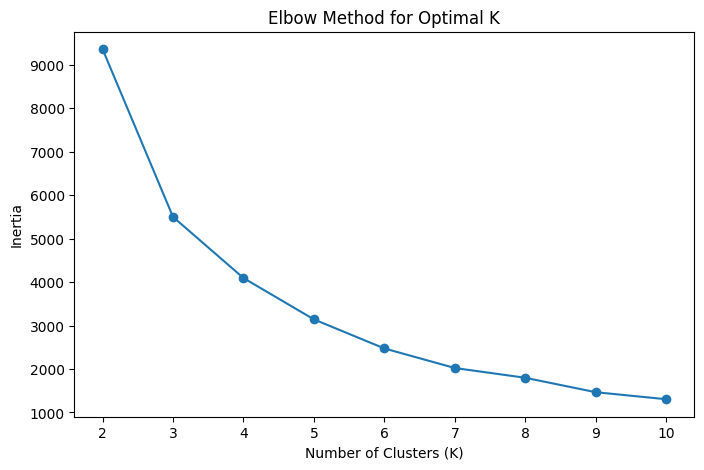

In [11]:
from sklearn.cluster import KMeans

inertia = []

K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

#### Elbow Method
The elbow curve shows a sharp decrease in inertia from **K = 2 to K = 4**, after which the improvement becomes much more gradual. This indicates that **4 clusters** provide a good balance between:
- Capturing meaningful customer differences  
- Avoiding over-segmentation  
Therefore, we choose **K = 4** as the optimal number of customer segments.

## Perform Customer Segmentation

In [12]:
# Train KMeans with optimal K
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


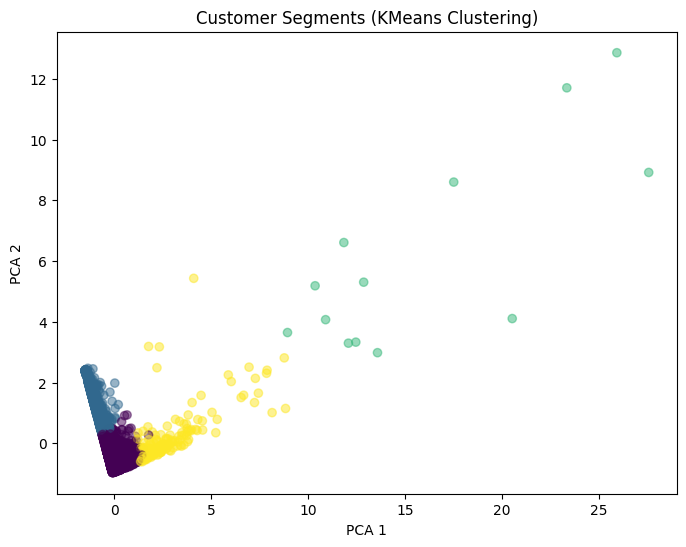

In [13]:
# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm["Cluster"], cmap="viridis", alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Customer Segments (KMeans Clustering)")
plt.show()

#### Customer Segmentation (KMeans)

The PCA visualization shows that customers have been clearly separated into **four distinct clusters** based on their purchasing behavior. We can observe:
- One large cluster of **low-value or infrequent shoppers**
- One group of **moderate, regular buyers**
- A smaller group of **high-spending or frequent customers**
- A small segment of **extreme high-value outliers**

The separation in PCA space confirms that KMeans has successfully identified meaningful customer groups rather than random partitions.

In [14]:
cluster_profile = rfm.groupby("Cluster").agg({"Recency": "mean","Frequency": "mean","Monetary": "mean","Cluster": "count"}).rename(columns={"Cluster": "CustomerCount"})
cluster_profile

,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,43.702685,3.682711,1359.049284,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


## Customer Segment Profiles

Using the RFM averages for each cluster, we can interpret the customer segments as follows:


## Cluster 0 — Regular Shoppers
**Size:** 3,054 customers  
**Behavior:** Moderate frequency and spending, decent recency  

These are customers who buy occasionally and contribute steady revenue. They are not premium users but are reliable.

**Strategy:**  
Send personalized recommendations and mild discounts to increase their purchase frequency.

## Cluster 1 — One-Time / Low-Value Buyers
**Size:** 1,067 customers  
**Behavior:** Very low frequency, low spending, long time since last purchase  

These users are at high risk of churn or may have only purchased once.

**Strategy:**  
Re-engage them using:
- Welcome-back discounts  
- Email reminders  
- Limited-time offers

## Cluster 2 — VIP / High-Value Customers
**Size:** 13 customers  
**Behavior:** Extremely high spending and very frequent purchases  

These are the most valuable customers and generate a disproportionate amount of revenue.

**Strategy:**  
Treat them as VIPs:
- Exclusive offers  
- Early access to products  
- Loyalty rewards  
- Dedicated support

## Cluster 3 — Loyal Power Users
**Size:** 204 customers  
**Behavior:** Very frequent buyers with high spending and recent activity  

These users are highly engaged and likely to respond well to personalization.

**Strategy:**  
Upsell and cross-sell:
- Recommend premium products  
- Offer bundles  
- Loyalty programs

## Conclusion

By applying RFM analysis, PCA, and KMeans clustering, we successfully converted raw transaction data into actionable customer segments.

Instead of treating all users the same, the business can now:
- Retain high-value customers  
- Re-engage inactive users  
- Increase revenue through targeted marketing  